In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
                                                       '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2'])

# Multiprocessing en python (muy simplificado)

El problema general es muy complejo. Nos concentraremos en una de las formas más simples, los problemas llamados _"ridículamente paralelizables"_(?). Es ideal para simulaciones Bootstrap y Monte Carlo en sus versiones simples.

## El problema que queremos resolver.

Dado un set de datos con errores, haremos una simulación de Monte Carlo estándar y buscaremos los intervalos de confianza al 68% para los parametros.

In [3]:
np.random.seed(43)
x_data = np.random.uniform(2, 6., size=40)
y_errs = np.random.uniform(2., 4., size=40)
y_data = -3. + 5 * x_data + np.random.normal(0, 1, size=40) * y_errs

<Container object of 3 artists>

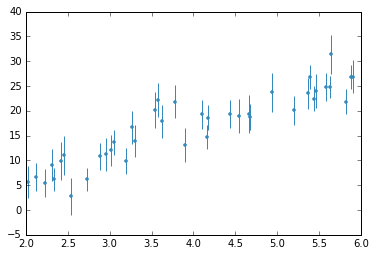

In [4]:
plt.errorbar(x_data, y_data, yerr=y_errs, ls='None', marker='.', capsize=0)

## Minimización usando $\chi^2$

In [5]:
from scipy.optimize import curve_fit

In [6]:
def model(x, a, b):
    return a + b * x

In [7]:
a_0 = [0, 10]
a_optimo, a_covarianza = curve_fit(model, x_data, y_data, a_0 , y_errs)

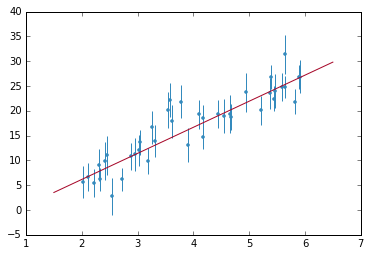

In [8]:
x_values = np.linspace(1.5, 6.5, 20)
plt.errorbar(x_data, y_data, yerr=y_errs, ls='None', marker='.', capsize=0)
p = plt.plot(x_values, model(x_values, *a_optimo))

In [9]:
print "a_optimo = ", a_optimo

a_optimo =  [-4.35405272  5.25645103]


## Ahora estimemos el intervalo de confianza con una simulación de Monte Carlo.

In [10]:
def una_simulacion_MC(i):
    # Notar que no se le pasan argumentos, usa x_data, y_data e y_errs que son variables globales
    perturbaciones = np.random.normal(0, 1, size=len(x_data)) * y_errs
    y_simulacion = y_data + perturbaciones
    b, a = np.polyfit(x_data, y_simulacion, 1)
    return [a, b]

In [13]:
%%timeit
N_mc = 100000

MC_output = np.zeros((N_mc, 2))
for i in range(N_mc):
    MC_output[i] = una_simulacion_MC(1)

1 loop, best of 3: 10.2 s per loop


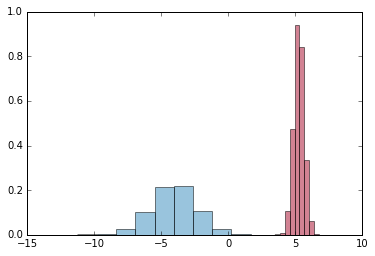

In [14]:
a_hist = plt.hist(MC_output[:,0], normed=True, alpha=0.5)
b_hist = plt.hist(MC_output[:,1], normed=True, alpha=0.5)

# Cómo podemos acelerar esta simulación?

Cada una de las simulaciones es independiente de la anterior, **no requiere ser realizada secuencialmente**.

In [15]:
from multiprocessing import Pool

In [19]:
%%timeit
N_procesos = 4
p = Pool(N_procesos)
result = p.map(una_simulacion_MC, range(N_mc))
p.close()
result = np.array(result)

1 loop, best of 3: 2.98 s per loop


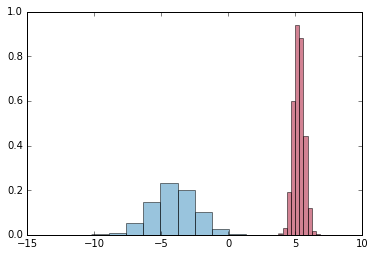

In [20]:
a_hist = plt.hist(result[:,0], normed=True, alpha=0.5)
b_hist = plt.hist(result[:,1], normed=True, alpha=0.5)